# 05 - Initial Feature Selection and Engineering
____



In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg


In [18]:
train = pd.read_csv('cleaned_training_data.csv', low_memory = False)
test = pd.read_csv('cleaned_testing_data.csv', low_memory = False)

We currently have 43 features plus our 1 predictor (casualty_severity). This many features (especially with many high cardinality features) is likely to lead to severe overfitting of our model. We need to get stuck into some feature selection.

In [19]:
train.shape

(532806, 41)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532806 entries, 0 to 532805
Data columns (total 41 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               532806 non-null  object 
 1   accident_year                                532806 non-null  int64  
 2   accident_reference                           532806 non-null  object 
 3   location_easting_osgr                        532806 non-null  float64
 4   location_northing_osgr                       532806 non-null  float64
 5   longitude                                    532806 non-null  float64
 6   latitude                                     532806 non-null  float64
 7   accident_severity                            532806 non-null  object 
 8   number_of_vehicles                           532806 non-null  int64  
 9   number_of_casualties                         532806 non-nul

* It seems like we have quite a few redundant features that we can get rid of, e.g. accident_reference, vehicle_reference and casualty_reference.
* All geographical idenftification features are going to be collision-specific and lead to overfitting. Same for the date and time features, however, we could extract some more generalised timedate information, such as Month and Hour of collision - especially as we've seen that rush hour sees an increase in severity.
* casualty_severity, enhanced_casualty_severity and enhanced_severity_collision are all modified versions of our predictor and will lead to overfitting. We can drop these.
* The age band of casualty will be used intsead of the continuous age feature.
* Local_authority_highway is duplicated information in local_authority_district, so we can drop.
* Whether a police officer attended the scene of the collision after the fact won't affect the severity of the collision.

In [21]:
cols_to_drop = ['accident_index', 'accident_reference', 'vehicle_reference', 'casualty_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'lsoa_of_accident_location', 'local_authority_ons_district', 'accident_severity', 'age_of_casualty', 'local_authority_highway', 'did_police_officer_attend_scene_of_accident']

for data in [train, test]:
  data.drop(columns=cols_to_drop, inplace=True)

Let's handle those overly-specific datetimes.

In [22]:
for data in [train, test]:
  data['Hour'] = pd.to_datetime(data['time'], format='%H:%M').dt.hour
  data['Month'] = pd.to_datetime(data['date'], format ='%d/%m/%Y').dt.month
  data['Day'] = pd.to_datetime(data['date'], format ='%d/%m/%Y').dt.day
  data.drop(columns=['time', 'date'], axis=1, inplace=True)

Also let's map the casualty_severity column to 0 or 1 so we can look at correlations.

In [23]:
severity_dict = {'Slight': 0, 'Serious': 1, 'Fatal': 1}


for data in [train, test]:
  data['casualty_severity'].replace(severity_dict, inplace=True)

Okay, let's check whether our remaining categories are associated with the collision_severity. If not, we can think about dropping these features.

To check, we will use the chi2 test of independence to test the association between each feature and the collision_severity. Can we assume independence of samples here? Maybe increased chance of Type I and Type II errors. More importantly, some of our features are most likely breaking the >5 observations rule. We should weed out these features are reduce the cardinality to make the Chi2 test appropriate to use for feature selection here.

We can also have a look at the correlation matrix to check whether any of our numerical features are correlated with one another.

In [24]:
numeric = train.select_dtypes(include=np.number)
categorical = train.select_dtypes(exclude=np.number).columns

<Axes: >

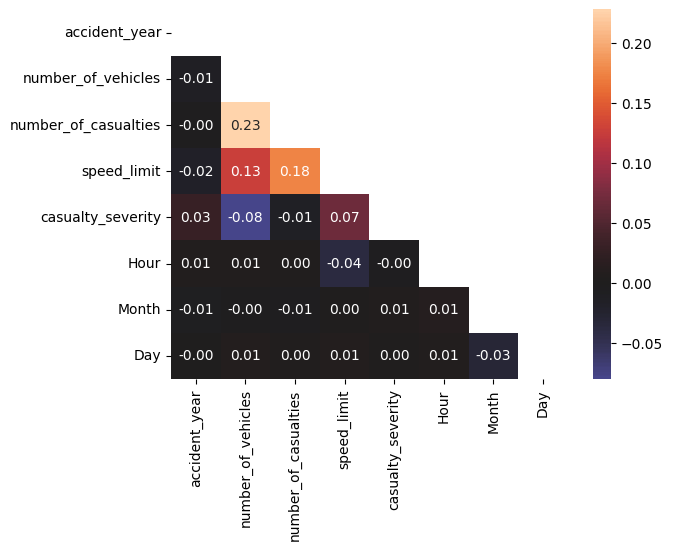

In [25]:
corr = numeric.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0, annot=True, fmt=".2f")

The number of vehicles and number of casualties are obviously correlated. We should consider combining these features into a new feature.

Let's find the categorical features that have low numbers of observations. Although the rule of thumb for the chi2 test is 5, let's pad this number out a bit as we don't know how unseen data might differ to this training set.

In [26]:
for col in categorical:
    if (train[col].value_counts() < len(train)*0.01).any():
        print(col)

first_road_class
second_road_class
pedestrian_crossing_human_control
pedestrian_crossing_physical_facilities
light_conditions
weather_conditions
road_surface_conditions
pedestrian_location
pedestrian_movement
bus_or_coach_passenger
pedestrian_road_maintenance_worker
casualty_type


To deal with the high cardinality, the most flexible option (that will translate well to unseen data) would be to group low frequency categories together as 'Other' within each feature. When we do this we need to be careful to not create additional 'Other' columns to ones that might already exist in the dataset.

Before we do this, let's just see whether we can combine the categories in a more clever way to retain some of the information.

* Starting with road_class, we can see that A(M) roads are seperated from motorways, however, in the UK the M suffix means this is a motorway. Let's roll the A(M)s into the motoroways, for the first_road_class and second_road_class too.



In [27]:
for data in [train, test]:
  data['first_road_class'].replace({'A(M)': 'Motorway'}, inplace=True)
  data['second_road_class'].replace({'A(M)': 'Motorway'}, inplace=True)

* Road_type and junction_detail can be reduced with an 'Other category' whilst we test for association.

In [28]:
train.road_type.value_counts()

road_type
Single carriageway    395725
Dual carriageway       87597
Roundabout             29583
One way street         10402
Slip road               9499
Name: count, dtype: int64

In [29]:
train.junction_detail.value_counts()

junction_detail
Not at junction or within 20 metres    235605
T or staggered junction                145190
Crossroads                              51737
Roundabout                              39159
Other junction                          28172
Private drive or entrance               11236
More than 4 arms (not roundabout)        7618
Mini-roundabout                          7313
Slip road                                6776
Name: count, dtype: int64

* pedestrian_crossing_human_control and pedestrian_crossing_physical_facilities likely contain similar information. Let's see.

In [30]:
train.pedestrian_crossing_physical_facilities.value_counts()

pedestrian_crossing_physical_facilities
No physical crossing facilities within 50 metres                             428283
Pedestrian phase at traffic signal junction                                   41169
Pelican, puffin, toucan or similar non-junction pedestrian light crossing     28691
Zebra                                                                         20462
Central refuge                                                                12956
Footbridge or subway                                                           1245
Name: count, dtype: int64

In [31]:
train.pedestrian_crossing_human_control.value_counts()

pedestrian_crossing_human_control
None within 50 metres                 524816
Control by other authorised person      5865
Control by school crossing patrol       2125
Name: count, dtype: int64

I think that pedestrain_crossing_human_control is mostly captured already in the pedestrian_crossing_physical_facilities. Let's drop the former and the latter is a good candidate for grouping together low frequency observations into an 'Other' category.

In [32]:
for data in [train, test]:
  data.drop(columns='pedestrian_crossing_human_control', axis=1, inplace=True)

* light_conditions - let's combine the truly dark categories as "Darkness". Maybe we could just have a feature for is_dark?

In [33]:
for data in [train, test]:
  data.loc[~data['light_conditions'].str.contains('daylight|darkness - lights lit', case=False), 'light_conditions'] = 'Darkness'

* weather_conditions looks like it can be collapsed down. Let's extract a 'high winds' feature and reduce the remaining categories.
* We can combine frost, ice and snow in the road conditions feature.

In [34]:
for data in [train, test]:
  data['high_winds'] = (data['weather_conditions'].str.contains(r"+ high winds", regex=False) == True)
  data['weather_conditions'] = data['weather_conditions'].str.replace(' no high winds', '')
  data['weather_conditions'] = data['weather_conditions'].str.replace(' + high winds', '')  

In [35]:
road_surface_dict = {'Frost or ice': 'Frost, ice or snow', 'Snow': 'Frost, ice or snow'}

for data in [train, test]:
  data['road_surface_conditions'].replace(road_surface_dict, inplace=True)

* pedestrian_location and pedestrian_movement likely contain similar information.

In [36]:
train.pedestrian_location.value_counts()

pedestrian_location
Not a Pedestrian                                                           460510
In carriageway, crossing elsewhere                                          27601
Crossing on pedestrian crossing facility                                    11910
On footway or verge                                                          8615
In carriageway, not crossing                                                 7513
Unknown or other                                                             6971
Crossing elsewhere within 50m. of pedestrian crossing                        4381
In centre of carriageway - not on refuge, island or central reservation      4380
On refuge, central island or central reservation                              474
Crossing in zig-zag approach lines                                            293
Crossing in zig-zag exit lines                                                158
Name: count, dtype: int64

In [37]:
train.pedestrian_movement.value_counts()

pedestrian_movement
Not a Pedestrian                                                                                             460506
Crossing from driver's nearside                                                                               22785
Unknown or other                                                                                              20405
Crossing from driver's offside                                                                                14834
In carriageway, stationary - not crossing  (standing or playing)                                               3725
Crossing from nearside - masked by parked or stationary vehicle                                                3587
Crossing from offside - masked by  parked or stationary vehicle                                                2679
Walking along in carriageway, back to traffic                                                                  1967
Walking along in carriageway, facing traffic        

pedestrian_movement and pedestrian_location are dominated by 'not a pedestrian' which maybe isn't helpful. From the other categories, except from 'unknown or other' it seems like all of these categories refer to a pedestrian being in the road. Let's just extract this as a 'pedestrian_in_carriageway' boolean feature and drop the original two columns.

In [38]:
ped_loc_list = ['In carriageway', 'Crossing', 'In centre of carriageway']
for data in [train, test]:
  data['pedestrian_in_carriageway'] = data['pedestrian_location'].str.contains("|".join(ped_loc_list))
  data.drop(columns=['pedestrian_movement', 'pedestrian_location'], axis=1, inplace=True)

* Categories in casualty_type can be collapsed down.

In [39]:
large_vehicles = ['Minibus', 'Agricultural vehicle', 'Goods vehicle', 'Van', 'Tram', 'Bus or coach']

for data in [train, test]:
  data.loc[data['casualty_type'].str.contains('motorcycle', regex=False, case=False), 'casualty_type'] = 'Motorcycle'
  data.loc[data['casualty_type'].str.contains('car', regex=False, case=False), 'casualty_type'] = 'Car occupant'
  data.loc[data['casualty_type'].str.contains("|".join(large_vehicles), regex=True, case=False), 'casualty_type'] = 'Large Vehicle'

* most casualties aren't bus or coach passengers (and the information is captured in "casualty_type"), but for the sake of testing the association with casualty_severity let's keep it for now (but tidied up)

In [40]:
for data in [train, test]:  
  data.loc[~data['bus_or_coach_passenger'].str.contains('Not a bus or coach passenger', regex=False, case=False), 'bus_or_coach_passenger'] = 'Bus or coach passenger'

There are only 8 instances of road workers in the dataset, let's just drop this feature.

In [41]:
print(train.pedestrian_road_maintenance_worker.value_counts())

for data in [train, test]:
  data.drop(columns='pedestrian_road_maintenance_worker', axis=1, inplace=True)

pedestrian_road_maintenance_worker
No / Not applicable    525472
Not Known                6709
Yes                       625
Name: count, dtype: int64


Okay let's see where we're up to with reducing the number of rare observations, so that we can apply our chi2 statistical test to check the association of each feature with the casualty_severity.

In [42]:
numeric = train.select_dtypes(include=np.number)
categorical = train.select_dtypes(exclude=[np.number, bool]).columns

for col in categorical:
    if (train[col].value_counts() < len(train)*0.01).any():
        print(col)

second_road_class
pedestrian_crossing_physical_facilities
weather_conditions
road_surface_conditions
casualty_type


Nice one. Okay let's roll any low frequency features (<1% of the dataset) into an 'Other' category for each feature. We just need to be aware that some features already have "Other" categories, they may just not be named as such.

We also need to handle exceptions where the 'Other' category still has less than our predetermined threshold of observations. Maybe we should just drop these incredibly rare cases.

Again, any transformations that we make based on the training data should be directly applied to the testing data.

In [43]:
for col in categorical:
    is_rare = train[col].value_counts().lt(len(data)*0.01)
    rare_vals = is_rare[is_rare == True].index.get_level_values(0)
    train.loc[(train[col].isin(rare_vals)), col] = 'Other'
    test.loc[(test[col].isin(rare_vals)), col] = 'Other'
    train.loc[train[col].str.contains('other', regex=False, case=False), col] = 'Other'
    test.loc[test[col].str.contains('other', regex=False, case=False), col] = 'Other'
    if (train[train[col] == 'Other'].shape[0] < len(data)*0.01) & ((train[train[col] == 'Other'].shape[0] != 0)):
      train.drop(train[train[col] == 'Other'].index, axis=0, inplace=True)
      test.drop(test[test[col] == 'Other'].index, axis=0, inplace=True)


Now we're ready to use the chi2 test of independency to see whether any of our features are independent of the casualty_severity. Any that are can be dropped.

In [44]:
alpha=0.05
independent_features = {}
pvals = {}

for col in categorical:
  expected, observed, stats = pg.chi2_independence(data=train, x='casualty_severity', y=col)
  pval = stats['pval'][0]
  pvals[col] = pval
  if pval > alpha:
    independent_features[col] = np.round(pval, 5)

print(independent_features)
  

{}


In [49]:
for data in [train, test]:
  data.drop(columns=independent_features.keys(), axis=1, inplace=True)

___
#### Okay, we're down to 23 features after some gentle feature selection.

This is still quite a lot of features for our model. Atleast we've reduced the cardinality of the features we have.

Let's test some models and see what sort of performance we're getting. We can try some recursive feature elimination to hone in on the most important features, and potentially revisit feature engineering to combine some of the more correlated features (no. of casualties and no. of vehicles) etc.

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530630 entries, 0 to 532805
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   accident_year                            530630 non-null  int64  
 1   number_of_vehicles                       530630 non-null  int64  
 2   number_of_casualties                     530630 non-null  int64  
 3   day_of_week                              530630 non-null  object 
 4   first_road_class                         530630 non-null  object 
 5   road_type                                530630 non-null  object 
 6   speed_limit                              530630 non-null  float64
 7   junction_detail                          530630 non-null  object 
 8   second_road_class                        530630 non-null  object 
 9   pedestrian_crossing_physical_facilities  530630 non-null  object 
 10  light_conditions                     

___ 
#### Time to encode and scale our data for modelling in Part 07

In [48]:
train.to_csv('feat_sel_training_data.csv', index=False)
test.to_csv('feat_sel_testing_data.csv', index=False)